<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegression" data-toc-modified-id="CatBoostRegression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegression</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor as catbreg
from lightgbm import LGBMRegressor as lgbmreg
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

Выполним ресемплирование по одному часу, агрегируем сумму значений

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [3]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

Визуализируем временной ряд

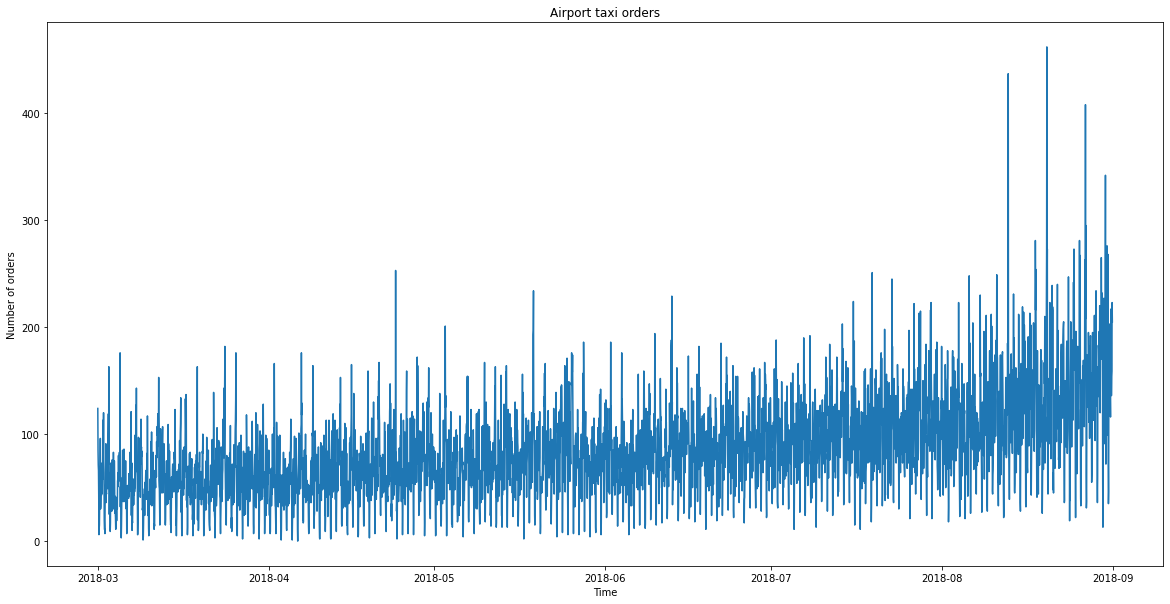

In [4]:
plt.figure(figsize=(20, 10))
plt.title('Airport taxi orders')
plt.xlabel('Time')
plt.ylabel('Number of orders')
plt.plot(df)

Разложим временной ряд на три составляющие: тренд, сезонность и шум

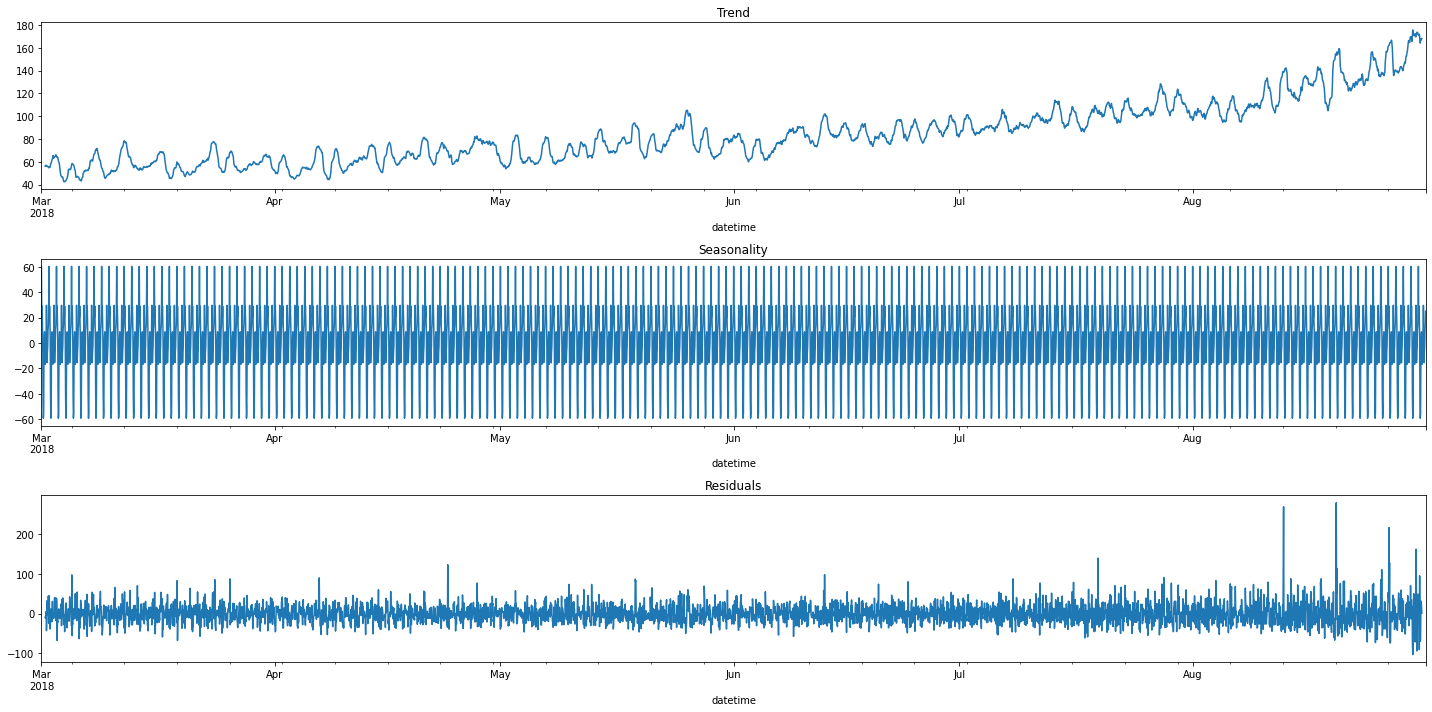

In [5]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(20, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Наблюдаем, что тренд на повышение

Напишем функцию с аргументами "max_lag" и "rolling_mean_size" для создания новых признаков <br>
_max_lag - задает максимальный размер отставания <br>_
_rolling_mean_size - задает ширину окна_

In [6]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df, 20, 20)

Выведем новый data frame

In [7]:
df.isna().sum().max()

20

In [8]:
df.dropna(inplace=True)

In [9]:
df

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 20:00:00,61,2018,3,1,3,45.0,73.0,44.0,43.0,66.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,53.30
2018-03-01 21:00:00,66,2018,3,1,3,61.0,45.0,73.0,44.0,43.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,50.15
2018-03-01 22:00:00,113,2018,3,1,3,66.0,61.0,45.0,73.0,44.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,49.20
2018-03-01 23:00:00,58,2018,3,1,3,113.0,66.0,61.0,45.0,73.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,51.30
2018-03-02 00:00:00,90,2018,3,2,4,58.0,113.0,66.0,61.0,45.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,50.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,169.35
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,163.85
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,157.75


## Обучение

Разобъем df на тестовую и тренировочную выборки
и выделим признаки и целевой признак в каждой из выборок

In [10]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

### LinearRegression

Обучим модель линейной регрессии

In [11]:
model = LinearRegression()
model.fit(train_features, train_target)

predicted_test = model.predict(test_features)
predicted_train = model.predict(train_features)

print("RMSE обучающей выборки:", mean_squared_error(train_target, predicted_train) ** 0.5)
print("RMSE тестовой выборки: ", mean_squared_error(test_target, predicted_test) ** 0.5)

RMSE обучающей выборки: 29.272671810257194
RMSE тестовой выборки:  54.99759418112109


### LGBMRegressor

Обучим модель LGBM регрессии c подбором параметров по GridSearchCV

In [12]:
tscv = TimeSeriesSplit(n_splits=2)

In [13]:
params = {
    'n_estimators':(800, 600),
    'learning_rate':[0.01, 0.05],
    'max_depth':[3]
}
lgb = lgb.LGBMRegressor()
lgb_cv = GridSearchCV(lgb, params, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)
lgb_cv.fit(train_features, train_target)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05], 'max_depth': [3],
                         'n_estimators': (800, 600)},
             scoring='neg_root_mean_squared_error')

Лучшие параметры после GridSearchCV:

In [14]:
lgb_cv.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 600}

In [15]:
predicted_train = lgb_cv.best_estimator_.predict(train_features)
predicted_test = lgb_cv.best_estimator_.predict(test_features)
print("RMSE обучающей выборки:", mean_squared_error(train_target, predicted_train) ** 0.5)
print("RMSE тестовой выборки: ", mean_squared_error(test_target, predicted_test) ** 0.5)
predicted_test_best = predicted_test
test_target_best = test_target
test_features_best = test_features

RMSE обучающей выборки: 18.455881171895548
RMSE тестовой выборки:  47.23801794460981


### CatBoostRegression

Обучим модель CatBoost регрессии c подбором параметров по GridSearchCV

In [16]:
params = {
    'n_estimators':(800, 600),
    'learning_rate':[0.01, 0.05],
    'max_depth':[3]
}
cbr = catbreg(verbose=False)
cbr_cv = GridSearchCV(cbr, params, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)
cbr_cv.fit(train_features, train_target)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f199eb24a00>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05], 'max_depth': [3],
                         'n_estimators': (800, 600)},
             scoring='neg_root_mean_squared_error')

Лучшие параметры после GridSearchCV:

In [17]:
cbr_cv.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 600}

In [18]:
predicted_train = cbr_cv.best_estimator_.predict(train_features)
predicted_test = cbr_cv.best_estimator_.predict(test_features)
print("RMSE обучающей выборки:", mean_squared_error(train_target, predicted_train) ** 0.5)
print("RMSE тестовой выборки: ", mean_squared_error(test_target, predicted_test) ** 0.5)

RMSE обучающей выборки: 21.292725139213623
RMSE тестовой выборки:  48.757565275600534


## Тестирование

In [19]:
data = [[29.27, 54.99],
       [18.45, 47.23],
       [21.29, 48.75]]
model_name = ['LinearRegression', 'LGBMRegresspor', 'CatBoostRegression']
col_name = ['train_score','test_score']

In [20]:
pd.DataFrame(data=data, index=model_name, columns=col_name)

,train_score,test_score
LinearRegression,29.27,54.99
LGBMRegresspor,18.45,47.23
CatBoostRegression,21.29,48.75


RMSE: 47.23801794460981


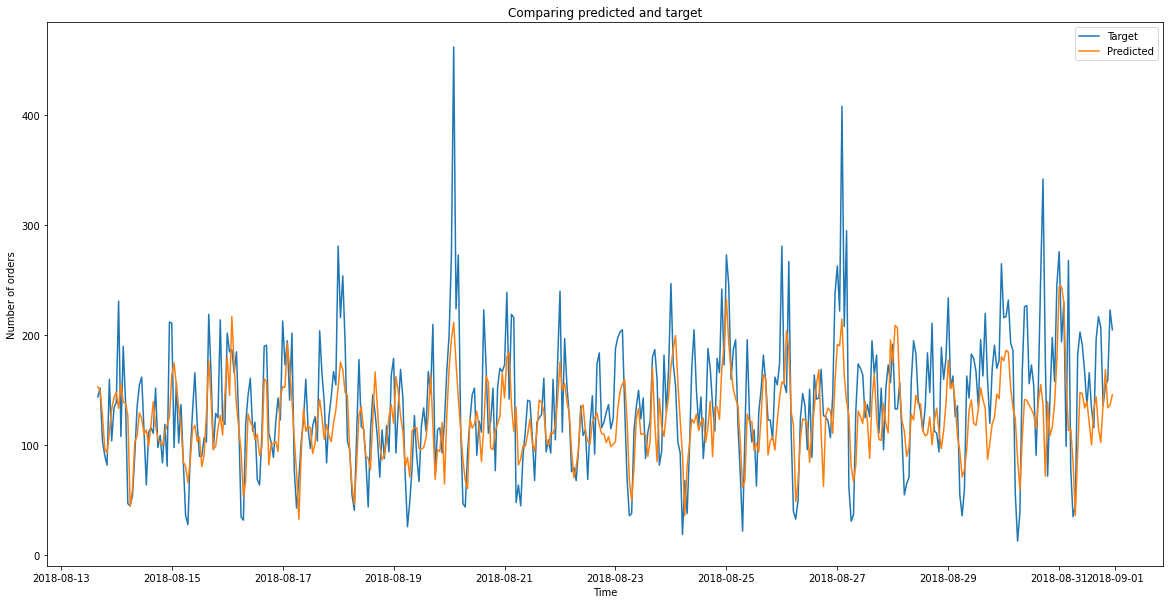

In [21]:
print("RMSE:", mean_squared_error(test_target_best, predicted_test_best) ** 0.5)
plt.figure(figsize=(20, 10))
plt.plot(test_features.index, test_target_best, label='Target')
plt.plot(test_features.index, predicted_test_best, label='Predicted')
plt.title('Comparing predicted and target')
plt.xlabel('Time')
plt.ylabel('Number of orders')
plt.legend()
plt.show()

Лучшая модель на тесте и на трейне - LGBMRegresspor, LinearRegression обучается быстрее, меньше переобучивается, но RMSE больше всех рассмотренных моделей